Our example: A WDM [1], similar to the structure given in [2].

[1] https://optics.ansys.com/hc/en-us/articles/4411329984147-KLayout-INTERCONNECT-interoperability-Wavelength-Division-Multiplexing-WDM

[2] https://www.fiberoptics4sale.com/blogs/wave-optics/wdm-components


Main performance parameters:

Channel center wavelength [3,4]

Bandwidth [3,4]

Insertion loss (transmission ratio) [2,3,4]

Isolation [2,3,4]

Polarization dependent loss [2,3,4]

Optical return loss [3,4]

Channel spacing [2]

[3] https://www.thorlabs.com/images/tabimages/RGB26HA_SampleDataSheet.pdf

[4] https://www.thorlabs.com/drawings/e201fa8fd45c7f5f-FA44855F-EF9B-C465-51B48D5B4CFD771C/RGB26HF-SpecSheet.pdf


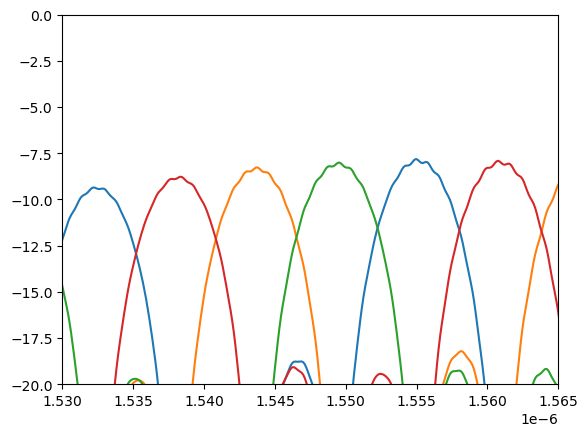

In [2]:
import numpy as np
import h5py

import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import find_peaks

number_of_channels = 4
wavelength_range = [1530e-9, 1565e-9]

wavelength_min = wavelength_range[0]
wavelength_max = wavelength_range[1]

channel_wavelength = {}
channel_TE_gain__dB_ = {}
peak_indices = {}
peak_wavelengths = {}
peak_gains = {}
peak_wavelength = {}
peak_gain = {}

cut_off_wavelength_1 = {}
cut_off_gain_1 = {}

cut_off_wavelength_2 = {}
cut_off_gain_2 = {}

bandwidth = {}

for x in range(1,number_of_channels+1):
    channel_data = h5py.File('h'+str(x)+'.mat','r')
    channel_wavelength[x] = channel_data.get('h'+str(x)+'/wavelength')
    channel_wavelength[x] = np.array(channel_wavelength[x]) 
    channel_TE_gain__dB_[x] = channel_data.get('h'+str(x)+'/TE_gain__dB_')
    channel_TE_gain__dB_[x] = np.array(channel_TE_gain__dB_[x]) 
    plot_x = channel_wavelength[x]
    plot_x = plot_x[0,:]
    plot_y = channel_TE_gain__dB_[x]
    plot_y = plot_y[:,0,0]
    plt.plot(plot_x, plot_y)
    peak_indices, _ = find_peaks(plot_y)
    peak_wavelengths[x] = plot_x[peak_indices]
    peak_gains[x] = plot_y[peak_indices]
    
    peak_wavelengths_ = peak_wavelengths[x]
    peak_gains_ = peak_gains[x]

    peak_wavelengths__ = peak_wavelengths_[(peak_wavelengths_>wavelength_min) & (peak_wavelengths_<wavelength_max)]
    peak_gains__ = peak_gains_[(peak_wavelengths_>wavelength_min) & (peak_wavelengths_<wavelength_max)]

    peak_wavelength[x] = peak_wavelengths__[(peak_gains__==max(peak_gains__))]
    peak_gain[x] = peak_gains__[(peak_gains__==max(peak_gains__))]

    cut_off_wavelengths = plot_x[(plot_y<peak_gain[x]-3+1) & (plot_y>peak_gain[x]-3-1)]
    cut_off_gains = plot_y[(plot_y<peak_gain[x]-3+1) & (plot_y>peak_gain[x]-3-1)]


    cut_off_wavelengths_1 = cut_off_wavelengths[(cut_off_wavelengths<peak_wavelength[x])]
    cut_off_wavelengths_2 = cut_off_wavelengths[(cut_off_wavelengths>peak_wavelength[x])]

    cut_off_gains_1 = cut_off_gains[(cut_off_wavelengths<peak_wavelength[x])]
    cut_off_gains_2 = cut_off_gains[(cut_off_wavelengths>peak_wavelength[x])]

    distance_1 = abs((cut_off_wavelengths_1-peak_wavelength[x]))
    distance_2 = abs((cut_off_wavelengths_2-peak_wavelength[x]))

    cut_off_wavelength_1[x] = cut_off_wavelengths_1[(abs(cut_off_wavelengths_1-peak_wavelength[x]) ==min(distance_1))]
    cut_off_wavelength_2[x] = cut_off_wavelengths_2[(abs(cut_off_wavelengths_2-peak_wavelength[x]) ==min(distance_2))]
    cut_off_gain_1[x] = cut_off_gains_1[(abs(cut_off_wavelengths_1-peak_wavelength[x]) ==min(distance_1))]
    cut_off_gain_2[x] = cut_off_gains_2[(abs(cut_off_wavelengths_2-peak_wavelength[x]) ==min(distance_2))]

    bandwidth[x] = cut_off_wavelength_2[x] - cut_off_wavelength_1[x]


plt.xlim([1.53e-6, 1.565e-6])
plt.ylim([-20, 0])
plt.show()



In [29]:
display(peak_wavelength)
display(bandwidth)
display(peak_gain)

{1: array([1.5549724e-06]),
 2: array([1.54376227e-06]),
 3: array([1.54957129e-06]),
 4: array([1.56075248e-06])}

{1: array([4.29141188e-09]),
 2: array([4.22853543e-09]),
 3: array([4.26041613e-09]),
 4: array([4.32337732e-09])}

{1: array([-7.8213261]),
 2: array([-8.27190424]),
 3: array([-8.01689539]),
 4: array([-7.91657597])}

Main loss functions: (to be continued)

SmoothL1loss [5,6]

MSE [7]

[5] https://hal.science/hal-04175312

[6] https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html

[7] https://photonix.springeropen.com/articles/10.1186/s43074-021-00044-y



In [26]:
from sklearn.metrics import mean_squared_error
# from sklearn import preprocessing
import numpy

specified_design_specs_label = ["bandwidth"]
specified_design_specs_in = [4e-9, 4e-9, 4e-9, 4e-9]
specified_design_specs_results = [bandwidth[1][0], bandwidth[2][0], bandwidth[3][0], bandwidth[4][0]]

nonspecified_design_specs_label = ["gain"]
nonspecified_design_specs_in = [-5, -5, -5, -5]
nonspecified_design_specs_results = [peak_gain[1][0], peak_gain[2][0], peak_gain[3][0], peak_gain[4][0]]


design_specs_labels = [specified_design_specs_label , nonspecified_design_specs_label]
design_specs_in = [specified_design_specs_in , nonspecified_design_specs_in]
design_specs_results = [specified_design_specs_results , nonspecified_design_specs_results]
weight_array = [ 1*numpy.ones(len(specified_design_specs_results)) , 1*numpy.ones(len(nonspecified_design_specs_results)) ]

def circuit_loss_function(design_specs_in, design_specs_results, weight_array):
    loss = mean_squared_error(design_specs_in, design_specs_results, sample_weight=weight_array)
    return loss

loss = circuit_loss_function(design_specs_in, design_specs_results, weight_array)

display(weight_array)

display(loss)


[array([1., 1., 1., 1.]), array([1., 1., 1., 1.])]

4.534163938509813

I think I should use different loss functions for different specs, MSE is not suitable for all specs (good for center wavelength, not good for insertion loss).